In [ ]:
import math
import json
import librosa
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
cp: cannot stat './kaggle.json': No such file or directory


In [ ]:
!pip  install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krishnathejusd
Your Kaggle Key: ··········


100%|██████████| 1.21G/1.21G [00:07<00:00, 169MB/s]


In [ ]:
def preprocess(dataset_path, num_mfcc=40, n_fft=2048, hop_length=512, num_segment=10):
  data ={"labels": [], "mfcc": []}
  sample_rate = 22050
  samples_per_segment = int(sample_rate*30/num_segment)

  for label_idx, (dirpath,dirnames,filenames) in enumerate(os.walk(dataset_path)):
    if dirpath == dataset_path:
      continue

    for f in sorted(filenames):
      if not f.endswith('.wav'):
        continue
      file_path = str(str(dirpath).split('//')[-1]) + '/' + str(f)
      print("Track Name ", file_path)

      try:
        y, sr = librosa.load(file_path, sr=sample_rate)
      except:
        continue
      for n in range(num_segment):
        mfcc = librosa.feature.mfcc(y[samples_per_segment*n: samples_per_segment*(n+1)],
                                    sample_rate, n_mfcc = num_mfcc, n_fft = n_fft,
                                    hop_length = hop_length)
        mfcc = mfcc.T
        if len(mfcc) == math.ceil(samples_per_segment/hop_length):
          data['mfcc'].append(mfcc.tolist())
          data['labels'].append(label_idx-1)

  return data

In [ ]:
mfcc_data = preprocess('/content/gtzan-dataset-music-genre-classification/Data/genres_original')

Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00000.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00001.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00002.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00003.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00004.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00005.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00006.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00007.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/classical/cla

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00055.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00056.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00057.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00058.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00059.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00060.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00061.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00062.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00063.wav
Track Name  /content/gtzan-dataset-music-genre-classification/Data/genres

In [ ]:
x = np.array(mfcc_data['mfcc'])
y = np.array(mfcc_data['labels'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

input_shape = (x_train.shape[1], x_train.shape[2])

In [ ]:
import tensorflow as tf

tf.random.set_seed(32)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=15)
model.save('GTZAN_LSTM.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 130, 64)           26880     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 64,714
Trainable params: 64,714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
188/188 [==============================] - 32s 147ms/step - loss: 1.7410 - accuracy: 0.3786 - val_loss: 1.5144 - val_accuracy: 0.4526
Epoch 2/15
188/188 [=================

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_test

array([0, 4, 2, ..., 3, 4, 6])

In [ ]:
np.sum(y_pred==y_test)/len(y_pred)

0.7392871445734882

In [ ]:
import pandas as pd

gtzan_data = pd.read_csv('/content/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
gtzan_data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
len(gtzan_data.columns)

60

In [ ]:
X = gtzan_data.iloc[:,1:-1]
y = gtzan_data.label

X_np = X.to_numpy()
print(X_np.shape)
X_ts = []
y_ts = []
window_size = 50

for i in range(X_np.shape[0]-window_size):
  X_ts.append(X_np[i: window_size + i,:].tolist())
  y_ts.append(y[i])

X_ts_np = np.array(X_ts, dtype=object).astype('float32')
y_ts_np = np.array(y_ts, dtype=object)

print(X_ts_np.shape)
print(y_ts_np.shape)

(9990, 58)
(9940, 50, 58)
(9940,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_ts_np = label_encoder.fit_transform(y_ts_np)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_ts_np, y_ts_np, test_size=0.2, stratify=y_ts_np, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
import tensorflow as tf

input_shape = X_train.shape[1:]
tf.random.set_seed(42)
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
model2.add(tf.keras.layers.LSTM(64))
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))


In [ ]:
optimiser = tf.keras.optimizers.Adam(lr=0.001)
model2.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()
model2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)
model2.save('GTZAN_full_LSTM.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            31488     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 69,322
Trainable params: 69,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
199/199 [==============================] - 19s 65ms/step - loss: 1.7000 - accuracy: 0.3782 - val_loss: 1.4360 - val_accuracy: 0.4004
Epoch 2/20
199/199 [====================

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)
model2.save('GTZAN_full_LSTM.h5')

Epoch 1/20
199/199 [==============================] - 14s 70ms/step - loss: 0.9431 - accuracy: 0.6409 - val_loss: 1.0823 - val_accuracy: 0.5864
Epoch 2/20
199/199 [==============================] - 12s 61ms/step - loss: 0.9303 - accuracy: 0.6430 - val_loss: 0.8998 - val_accuracy: 0.6681
Epoch 3/20
199/199 [==============================] - 12s 62ms/step - loss: 0.8805 - accuracy: 0.6648 - val_loss: 0.9252 - val_accuracy: 0.6574
Epoch 4/20
199/199 [==============================] - 15s 75ms/step - loss: 0.8239 - accuracy: 0.6859 - val_loss: 0.8828 - val_accuracy: 0.6744
Epoch 5/20
199/199 [==============================] - 12s 62ms/step - loss: 0.8123 - accuracy: 0.6955 - val_loss: 0.7678 - val_accuracy: 0.7253
Epoch 6/20
199/199 [==============================] - 23s 114ms/step - loss: 0.8099 - accuracy: 0.6964 - val_loss: 0.7743 - val_accuracy: 0.7209
Epoch 7/20
199/199 [==============================] - 21s 106ms/step - loss: 0.7628 - accuracy: 0.7150 - val_loss: 0.8321 - val_accurac

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5)
model2.save('GTZAN_full_LSTM.h5')

Epoch 1/5
199/199 [==============================] - 13s 64ms/step - loss: 0.4976 - accuracy: 0.8129 - val_loss: 0.5315 - val_accuracy: 0.8026
Epoch 2/5
199/199 [==============================] - 13s 64ms/step - loss: 0.5192 - accuracy: 0.8007 - val_loss: 0.5377 - val_accuracy: 0.8001
Epoch 3/5
199/199 [==============================] - 12s 60ms/step - loss: 0.5196 - accuracy: 0.8035 - val_loss: 0.5428 - val_accuracy: 0.8014
Epoch 4/5
199/199 [==============================] - 12s 60ms/step - loss: 0.4650 - accuracy: 0.8209 - val_loss: 0.5457 - val_accuracy: 0.7863
Epoch 5/5
199/199 [==============================] - 12s 60ms/step - loss: 0.5714 - accuracy: 0.7889 - val_loss: 0.5491 - val_accuracy: 0.7945


In [ ]:
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

np.sum(y_pred==y_test)/len(y_pred)

0.7932595573440644

# Music Genre Classification using CNN

In [ ]:
x = np.array(mfcc_data['mfcc'])
y = np.array(mfcc_data['labels'])

x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = tf.keras.utils.to_categorical(y, num_classes=10)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

y_train[y_train==10] = 9
y_val[y_val==10] = 9
y_test[y_test==10] = 9

input_shape = x_train.shape[1:]

In [ ]:
from tensorflow.keras import layers, models
input_shape = x_train.shape[1:]

cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='valid', input_shape=input_shape),
    layers.MaxPooling2D(2, padding='same'),

    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D(2, padding='same'),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.MaxPooling2D(2, padding='same'),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 38, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 17, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 9, 128)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 31, 9, 128)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 7, 128)       

In [ ]:
history = cnn_model.fit(x_train, y_train, 
                        validation_data=(x_val, y_val),
                        epochs=40,
                        batch_size=32)

Epoch 1/40
188/188 [==============================] - 113s 599ms/step - loss: 0.2078 - acc: 0.5296 - val_loss: 0.2366 - val_acc: 0.4453
Epoch 2/40
188/188 [==============================] - 114s 607ms/step - loss: 0.1805 - acc: 0.5999 - val_loss: 0.2023 - val_acc: 0.5327
Epoch 3/40
188/188 [==============================] - 97s 517ms/step - loss: 0.1615 - acc: 0.6546 - val_loss: 0.1586 - val_acc: 0.6589
Epoch 4/40
188/188 [==============================] - 74s 395ms/step - loss: 0.1469 - acc: 0.6920 - val_loss: 0.1416 - val_acc: 0.7109
Epoch 5/40
188/188 [==============================] - 76s 405ms/step - loss: 0.1340 - acc: 0.7288 - val_loss: 0.1359 - val_acc: 0.7343
Epoch 6/40
188/188 [==============================] - 74s 396ms/step - loss: 0.1233 - acc: 0.7525 - val_loss: 0.1238 - val_acc: 0.7490
Epoch 7/40
188/188 [==============================] - 76s 407ms/step - loss: 0.1132 - acc: 0.7777 - val_loss: 0.1196 - val_acc: 0.7470
Epoch 8/40
188/188 [==============================] -

In [ ]:
import pandas as pd

his = pd.DataFrame(history.history)
his.head()

,loss,acc,val_loss,val_acc
0,0.207801,0.529628,0.236555,0.445260
1,0.180527,0.599900,0.202310,0.532710
2,0.161487,0.654649,0.158566,0.658879
3,0.146859,0.692038,0.141622,0.710948
4,0.133994,0.728760,0.135917,0.734312


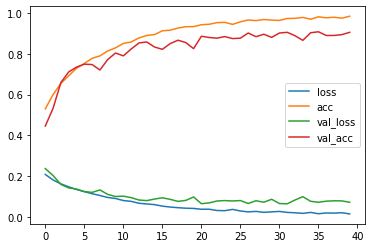

In [ ]:
his.plot()

In [ ]:
y_pred = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

np.sum(y_pred==y_test)/len(y_pred)

0.9054865839006808